# Portfolio Optimization with Genetic Algorithm

$ min -U = -(E(R_p)-\frac{1}{2}A{\sigma_p}^2) $  
$= -(\sum\limits_{i} {r_i}{W_i}-\frac{1}{2}A\sum\limits_{i}\sum\limits_{j} {\sigma_{ij}}^2W_iW_j) $  
$ s.t. $  
$ \sum\limits_{i} W_i=1 $  
$ 0 < W_i < 1,\forall i$

## Import Libraries

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import seaborn as sns

# Data Preparation

Data Source: Yahoo Finance (yfinance package)  
Universe: GICS Sector Index ETF  
Instrument: Select Sector SPDR ETFs  
Benchmark: S&P 500 ETF (Instrument Ticker: SPY) & Equal-Weighted  
Lookback Window: 4 Years (IS: 2019-2022)

## Universe Definition

In [ ]:
universe = {'XLC':'Communication Services',
            'XLY':'Consumer Discretionary',
            'XLP':'Consumer Staples',
            'XLE':'Energy',
            'XLF':'Financials',
            'XLV':'Health Care',
            'XLI':'Industrials',
            'XLB':'Materials',
            'XLRE':'Real Estate',
            'XLK':'Technology',
            'XLU':'Utilities'}
tickers = list(universe.keys())

## Data

### Loading Data

In [ ]:
df_bm = yf.download(tickers="SPY", start="2019-01-01", end="2022-12-31", repair=True)
df_ohlcv = yf.download(tickers=' '.join(tickers), start="2019-01-01", end="2022-12-31", repair=True)
df_close = df_ohlcv['Adj Close']
df_bm_return = np.log(df_bm/df_bm.shift(1)).dropna()
df_return = np.log(df_close/df_close.shift(1)).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  11 of 11 completed


### Descriptive Statistics

In [ ]:
df_bm_return['Adj Close'].describe()

count    1007.000000
mean        0.000488
std         0.014262
min        -0.115886
25%        -0.005305
50%         0.000900
75%         0.007478
max         0.086731
Name: Adj Close, dtype: float64

In [ ]:
df_return.describe()

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,0.000505,0.000170,0.000615,0.000434,0.000484,0.000734,0.000492,0.000326,0.000427,0.000533,0.000296
std,0.016250,0.016116,0.024881,0.018014,0.015907,0.018405,0.011471,0.016280,0.015077,0.012633,0.016900
min,-0.116628,-0.119679,-0.224910,-0.147449,-0.120408,-0.148662,-0.098668,-0.174367,-0.120561,-0.103818,-0.135460
25%,-0.007357,-0.007281,-0.010569,-0.007457,-0.006154,-0.008047,-0.003838,-0.006562,-0.006063,-0.005023,-0.006442
50%,0.000891,0.001074,0.000887,0.000822,0.001083,0.001156,0.000727,0.001105,0.001151,0.000901,0.001349
75%,0.008819,0.008155,0.013033,0.009094,0.008037,0.010457,0.005663,0.007949,0.006954,0.006760,0.008825
max,0.111184,0.086087,0.148742,0.123603,0.119126,0.110932,0.081678,0.084158,0.120388,0.074233,0.089655


## Parameter & Fitness Calculation

### Relevant Functions

In [ ]:
def calculate_cagr(x, avg_trading_days=252):
    '''
    Calculates CAGR as a measure of annualized mean return.
    CAGR: Compound Annual Growth Rate.
    
    Parameters
    -------
    x: pd.Series
        list of daily log returns
    avg_trading_days: int or float
        average trading days in a year
        
    Returns
    -------
    pd.Series
        CAGR
    '''
    return np.exp(x.sum()) ** (avg_trading_days/len(x)) - 1

In [ ]:
def calculate_var(x, avg_trading_days=252):
    '''
    Calculates variance as a measure of annualized risk.

    Parameters
    -------
    x: pd.Series
        list of daily log returns
    avg_trading_days: int or float
        average trading days in a year
        
    Returns
    -------
    pd.Series
        variance
    '''
    return (np.std(x)**2) * avg_trading_days

In [ ]:
def calculate_cov(x, avg_trading_days=252):
    '''
    Calculates annualized covariance.

    Parameters
    -------
    x: pd.DataFrame
        table of list of daily log returns
    avg_trading_days: int or float
        average trading days in a year
        
    Returns
    -------
    pd.DataFrame
        covariance matrix
    '''
    return x.cov() * avg_trading_days

In [ ]:
def portfolio_cagr(cagrs, weights):
    '''
    Calculates cagr of weighted portfolio.

    Parameters
    -------
    cagrs: np.array
        array of cagrs
    weights: np.array
        array of weights
        
    Returns
    -------
    float
        portfolio cagr
    '''
    return np.sum(np.multiply(cagrs, weights))

In [ ]:
def portfolio_var(cov, weights):
    '''
    Calculates variance of weighted portfolio.

    Parameters
    -------
    cov: pd.DataFrame
        table of covariance matrix
    weights: np.array
        array of weights
        
    Returns
    -------
    float
        portfolio variance
    '''
    var = np.matmul(np.matmul(weights, np.array(cov)), weights.T)
    return var

In [ ]:
def utility(mu, var, risk_aversion):
    '''
    Calculates utility of an investment.

    Parameters
    -------
    mu: float
        expected return of the investment
    sigma: float
        risk (volatility) of the investment
    risk_aversion: float
        risk aversion of the investor
        
    Returns
    -------
    float
        investment utility
    '''
    return mu - 0.5 * risk_aversion * var

In [ ]:
def portfolio_utility(cagrs, cov, weights, risk_aversion):
    '''
    Calculates utility of weighted portfolio.

    Parameters
    -------
    cagrs: np.array
        array of cagrs
    cov: pd.DataFrame
        table of covariance matrix
    weights: np.array
        array of weights
    risk_aversion: float
        risk aversion of the investor
        
    Returns
    -------
    float
        portfolio utility
    '''
    mu = portfolio_cagr(cagrs, weights)
    var = portfolio_var(cov, weights)
    return utility(mu, var, risk_aversion)

### Examples

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)

for i, v in enumerate(tickers):
    print(f"CAGR of {v}:\t {cagrs[i]:.2f}")
cov

CAGR of XLC:	 0.04
CAGR of XLY:	 0.08
CAGR of XLP:	 0.13
CAGR of XLE:	 0.17
CAGR of XLF:	 0.12
CAGR of XLV:	 0.14
CAGR of XLI:	 0.13
CAGR of XLB:	 0.14
CAGR of XLRE:	 0.09
CAGR of XLK:	 0.20
CAGR of XLU:	 0.11


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
XLB,0.066543,0.046741,0.071962,0.064364,0.059312,0.056679,0.033645,0.049291,0.040125,0.038765,0.053639
XLC,0.046741,0.065449,0.049000,0.050880,0.046002,0.065507,0.029945,0.043402,0.032301,0.036400,0.057586
XLE,0.071962,0.049000,0.156009,0.084239,0.072895,0.056966,0.033312,0.053254,0.040929,0.040176,0.056225
XLF,0.064364,0.050880,0.084239,0.081775,0.065867,0.060169,0.036364,0.054413,0.043371,0.041812,0.058100
XLI,0.059312,0.046002,0.072895,0.065867,0.063761,0.056168,0.034005,0.049998,0.040713,0.038547,0.053974
XLK,0.056679,0.065507,0.056966,0.060169,0.056168,0.085367,0.036722,0.052652,0.039662,0.045474,0.068826
XLP,0.033645,0.029945,0.033312,0.036364,0.034005,0.036722,0.033156,0.035337,0.034497,0.028751,0.031837
XLRE,0.049291,0.043402,0.053254,0.054413,0.049998,0.052652,0.035337,0.066788,0.049877,0.038857,0.048856
XLU,0.040125,0.032301,0.040929,0.043371,0.040713,0.039662,0.034497,0.049877,0.057284,0.034199,0.035366
XLV,0.038765,0.036400,0.040176,0.041812,0.038547,0.045474,0.028751,0.038857,0.034199,0.040215,0.037707


In [ ]:
# example portfolio: equal-weighted portfolio
weights = np.array([1/len(tickers)]*len(tickers)) # EW

for ra in np.linspace(1, 5, 5):
    u = portfolio_utility(cagrs, cov, weights, risk_aversion=ra)
    print(f"Portfolio Utility for Risk Aversion of {ra:.0f}: {u:.4f}")

Portfolio Utility for Risk Aversion of 1: 0.0977
Portfolio Utility for Risk Aversion of 2: 0.0728
Portfolio Utility for Risk Aversion of 3: 0.0479
Portfolio Utility for Risk Aversion of 4: 0.0231
Portfolio Utility for Risk Aversion of 5: -0.0018


In [ ]:
# mean-variance space
weights = np.array([1/len(tickers)]*len(tickers)) # EW

mv = dict()
for ticker in tickers:
    mv[ticker] = {'return':calculate_cagr(df_return[ticker]),
                  'risk':calculate_var(df_return[ticker])}
mv["SPY"] = {'return':calculate_cagr(df_bm_return['Adj Close']),
             'risk':calculate_var(df_bm_return['Adj Close'])}
mv["EW"] = {'return':portfolio_cagr(cagrs, weights),
             'risk':portfolio_var(cov, weights)}

df_mv = pd.DataFrame(mv).T

In [ ]:
df_mv = pd.DataFrame(mv).T

In [ ]:
df_mv['risk'].iloc[:-2]

XLC     0.065384
XLY     0.071899
XLP     0.033123
XLE     0.155854
XLF     0.081693
XLV     0.040175
XLI     0.063698
XLB     0.066477
XLRE    0.066722
XLK     0.085282
XLU     0.057228
Name: risk, dtype: float64

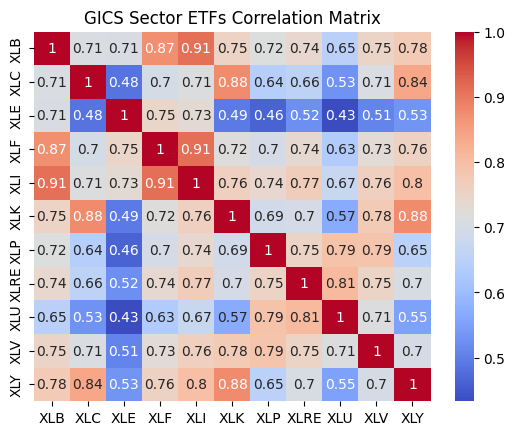

In [ ]:
fig, ax = plt.subplots()
ax = sns.heatmap(df_return.corr(), cmap="coolwarm", annot=True)
ax.set_title("GICS Sector ETFs Correlation Matrix")
fig.figure.savefig("Correlation_Sectors.png", dpi=300)

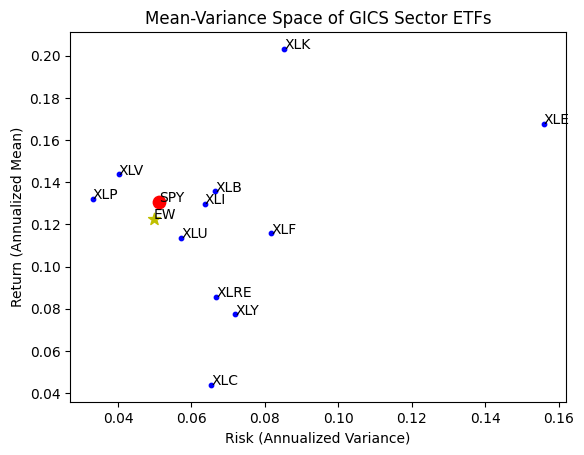

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Mean-Variance Space of GICS Sector ETFs')
ax.set_xlabel('Risk (Annualized Variance)')
ax.set_ylabel('Return (Annualized Mean)')

ax.scatter(df_mv['risk'].iloc[:-2], df_mv['return'].iloc[:-2],
           c='b', s=10)
ax.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
           c='r', s=80)
ax.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
           c='y', s=80, marker="*")
for i, v in enumerate(df_mv.index):
    ax.annotate(v, (df_mv['risk'].iloc[i], df_mv['return'].iloc[i]))

_ = fig.figure.savefig('Mean_Variance_Sectors.png', dpi=300)

# Intialization

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
    return - portfolio_utility(cagrs, cov, weights, risk_aversion)

In [ ]:
weights = np.array([1/len(tickers)]*len(tickers))
print(f"EW Fitness: {fitness(weights):.4f}")

EW Fitness: -0.0479


# Intial Population

In [ ]:
def generate_chromosome(n):
    '''
    Generates set of random numbers whose sum is equal to 1.
    
    Parameters
    -------
    n: int
        number of assets
        
    Returns
    -------
    np.array
        random weights
    '''
    chromosome = np.random.rand(n)
    return chromosome / np.sum(chromosome)

In [ ]:
# example of chromosome
child = generate_chromosome(4)
print(child, sum(child))

[0.10981149 0.46900639 0.13886073 0.28232138] 1.0


In [ ]:
# generate initial population
n = len(tickers) # number of assets
pop_size = 100 # intial population

population = np.array([generate_chromosome(n) for _ in range(pop_size)])
print(population.shape)

(100, 11)


# Elite Population

In [ ]:
def select_elite(population, frac=0.3):
    '''
    Selects elite population.
    
    Parameters
    -------
    population: np.array
        population of interest
    frac: float
        fraction of population to be considered as elite
        
    Returns
    -------
    np.array
        elite population
    '''
    population = sorted(population, key=lambda x: fitness(x), reverse=False)
    idx = int(np.floor(len(population)*frac))
    return population[:idx]

In [ ]:
# example of elite population
elite = select_elite(population)
print(f"First Elite Fitness: {portfolio_utility(cagrs, cov,elite[0], ra):.2f}")
print(f"Last Elite Fitness: {portfolio_utility(cagrs, cov, elite[-1], ra):.2f}")

First Elite Fitness: 0.07
Last Elite Fitness: 0.05


# Mutation

In [ ]:
def mutation(parent):
    '''
    Randomly choosen elements of a chromosome are swapped.
    
    Parameters
    -------
    parent: np.array
        parent chromosome
        
    Returns
    -------
    np.array
        child chromosome
    '''
    child = parent.copy()
    while True:
        # randomly choose 2 numbers in range of number of assets
        n = np.random.choice(range(parent.shape[0]), 2)
        # iterate until 2 choosen numbers are different
        if n[0] == n[1]:
            continue
        else:
            break
    child[n[0]], child[n[1]] = child[n[1]], child[n[0]]
    return child

In [ ]:
# example of mutation
print("Before Mutation: ", population[0])
print("After Mutation: ", mutation(population[0]))

Before Mutation:  [0.04657351 0.06164961 0.18129879 0.12628019 0.15499915 0.0582935
 0.04952192 0.03549466 0.12972463 0.090429   0.06573504]
After Mutation:  [0.04657351 0.06164961 0.18129879 0.12628019 0.0582935  0.15499915
 0.04952192 0.03549466 0.12972463 0.090429   0.06573504]


# Crossover

## Blended Crossover

$ Offspring_1 = Parent_{Best} + \beta ( Parent_{Best} - Parent_{Worst} ) $  
$ Offspring_2 = Parent_{Worst} - \beta ( Parent_{Best} - Parent_{Worst} ) $  
$ \beta \sim Unif(0, 1) $

In [ ]:
def blended_crossover(parent1, parent2):
    '''
    Perform blended crossover.
    
    Parameters
    -------
    parent1: np.array
        first parent
    parent2: np.array
        second parent
        
    Returns
    -------
    tuple(np.array, np.array)
        two children
    '''
    beta = np.random.rand() # unif(0, 1)

    if fitness(parent1) < fitness(parent2):
        # parent1 is best and parent 2 is worst
        child1 = parent1 + beta * (parent1-parent2)
        child2 = parent2 - beta * (parent1-parent2)
    else:
        # parent 2 is best and parent 1 is worst
        child1 = parent2 + beta * (parent2-parent1)
        child2 = parent1 - beta * (parent2-parent1)

    return child1, child2

In [ ]:
# example of blended crossover
print("<<Blended Crossover Example>>")
print("")
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
for i, v in enumerate(blended_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)

<<Blended Crossover Example>>

Parent1 Fitness: -0.0442
[0.04657351 0.06164961 0.18129879 0.12628019 0.15499915 0.0582935
 0.04952192 0.03549466 0.12972463 0.090429   0.06573504]
Parent2 Fitness: -0.0437
[0.08971803 0.03937741 0.07248693 0.11513559 0.10904975 0.09954848
 0.0013697  0.13730542 0.15942094 0.07738657 0.09920118]
Child1 Fitness: -0.0411
[ 0.01062579  0.08020666  0.27196009  0.13556579  0.19328388  0.02392013
  0.08964202 -0.04933338  0.10498187  0.10129586  0.03785128]
Child2 Fitness: -0.0397
[ 0.12566575  0.02082036 -0.01817438  0.10584999  0.07076502  0.13392185
 -0.03875041  0.22213346  0.18416371  0.06651971  0.12708494]


## Arithmetic Crossover

$ Offspring_1 = \alpha Parent_1 + ( 1 - \alpha ) Parent_2 $  
$ Offspring_2 = ( 1 - \alpha ) Parent_1 + \alpha Parent_2$  
$ \alpha \sim Unif(0, 1) $

In [ ]:
def arithmetic_crossover(parent1, parent2):
    '''
    Perform arithmetic crossover.
    
    Parameters
    -------
    parent1: np.array
        first parent
    parent2: np.array
        second parent
        
    Returns
    -------
    tuple(np.array, np.array)
        two children
    '''
    alpha = np.random.rand() # unif(0, 1)
    child1 = alpha * parent1 + (1-alpha) * parent2
    child2 = (1-alpha) * parent1 + alpha * parent2
    return child1, child2

In [ ]:
# example of arithmetic crossover
print("<<Arithmetic Crossover Example>>")
print("")
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
for i, v in enumerate(arithmetic_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)

<<Arithmetic Crossover Example>>

Parent1 Fitness: -0.0442
[0.04657351 0.06164961 0.18129879 0.12628019 0.15499915 0.0582935
 0.04952192 0.03549466 0.12972463 0.090429   0.06573504]
Parent2 Fitness: -0.0437
[0.08971803 0.03937741 0.07248693 0.11513559 0.10904975 0.09954848
 0.0013697  0.13730542 0.15942094 0.07738657 0.09920118]
Child1 Fitness: -0.0443
[0.04846572 0.06067281 0.17652656 0.12579141 0.15298392 0.06010284
 0.04741008 0.03995984 0.13102704 0.08985699 0.06720279]
Child2 Fitness: -0.0438
[0.08782581 0.04035422 0.07725915 0.11562437 0.11106498 0.09773914
 0.00348154 0.13284025 0.15811853 0.07795858 0.09773344]


## Uniform Crossover

$ Offspring_1[i] = Parent_1[i] and Offspring_2[i] = Parent_2[i] (r > 0.5) $  
$ Offspring_1[i] = Parent_2[i] and Offspring_2[i] = Parent_1[i] (otherwise) $  
$ r \sim Unif(0, 1) $

In [ ]:
def uniform_crossover(parent1, parent2):
    '''
    Perform uniform crossover.
    
    Parameters
    -------
    parent1: np.array
        first parent
    parent2: np.array
        second parent
        
    Returns
    -------
    tuple(np.array, np.array)
        two children
    '''
    child1 = []
    child2 = []
    for i in range(len(parent1)):
        r = np.random.rand() # unif(0, 1)
        if r > 0.5:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])
    
    return np.array(child1), np.array(child2)

In [ ]:
# example of uniform crossover
print("<<Uniform Crossover Example>>")
print("")
print(f"Parent1 Fitness: {fitness(population[0]):.4f}")
print(population[0])
print(f"Parent2 Fitness: {fitness(population[1]):.4f}")
print(population[1])
for i, v in enumerate(uniform_crossover(population[0], population[1])):
    print(f"Child{i+1} Fitness: {fitness(v):.4f}")
    print(v)

<<Uniform Crossover Example>>

Parent1 Fitness: -0.0442
[0.04657351 0.06164961 0.18129879 0.12628019 0.15499915 0.0582935
 0.04952192 0.03549466 0.12972463 0.090429   0.06573504]
Parent2 Fitness: -0.0437
[0.08971803 0.03937741 0.07248693 0.11513559 0.10904975 0.09954848
 0.0013697  0.13730542 0.15942094 0.07738657 0.09920118]
Child1 Fitness: -0.0386
[0.08971803 0.03937741 0.18129879 0.12628019 0.10904975 0.0582935
 0.0013697  0.03549466 0.12972463 0.07738657 0.09920118]
Child2 Fitness: -0.0490
[0.04657351 0.06164961 0.07248693 0.11513559 0.15499915 0.09954848
 0.04952192 0.13730542 0.15942094 0.090429   0.06573504]


# Next Generation

In [ ]:
def next_generation(pop_size, elite, crossover, frac=0.3):
    '''
    Perform mutation and crossover and build a new generation of chromosomes.
    
    Parameters
    -------
    pop_size: int
        size of population
    elite: np.array
        elite population
    crossover: function
        crossover method
    frac: float
        fraction of final stages
    
    Returns
    -------
    np.array
        new generation of chromosomes
    '''
    new_population = []
    elite_range = range(len(elite))

    while len(new_population) < pop_size:
        # choose randomly between crossover and mutation
        if len(new_population) > (1-frac) * pop_size:
            # mutation frequency decreased in final stages
            # r.v. assgining 0 for crossover 1 for mutation
            co_or_mutate = np.random.choice([0,1], p=[0.9,0.1])
        else:
            co_or_mutate = np.random.choice([0,1], p=[0.6, 0.4])
        
        if co_or_mutate == 1:
            # perform mutation
            idx = np.random.choice(elite_range)
            new_population.append(mutation(elite[idx]))
        else:
            # perform crossover
            while True:
                # iterate until all elements are positive
                p1_idx, p2_idx = np.random.choice(elite_range, 2)
                c1, c2 = crossover(elite[p1_idx], elite[p2_idx])
                if min(np.min(c1), np.min(c2)) > 0:
                    # check whether all elements are positive
                    break
                else:
                    continue
            new_population.extend([c1, c2])
    return np.array(new_population)[:100] # do not allow larger than 100

In [ ]:
# example of next generation
print(next_generation(pop_size, elite, blended_crossover).shape)

(100, 11)


# Optimization by Iteration

## With Blended Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
    return -portfolio_utility(cagrs, cov, weights, risk_aversion)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Blended Crossover"
cross_over_func = blended_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':portfolio_cagr(cagrs, elite[0]),
                         'risk':portfolio_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


In [ ]:
print("<<Optimization Result>>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (-Utility): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<<Optimal Solution (Weights)>>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<<Optimization Result>>
Return (Mean): 		0.1801
Risk (Variance): 	0.0413
fitness (-Utility): 	-0.1181

<<Optimal Solution (Weights)>>
XLC  (Communication Services) :	 0.0000
XLY  (Consumer Discretionary) :	 0.0074
XLP  (Consumer Staples)       :	 0.0089
XLE  (Energy)                 :	 0.0832
XLF  (Financials)             :	 0.0207
XLV  (Health Care)            :	 0.0118
XLI  (Industrials)            :	 0.0204
XLB  (Materials)              :	 0.0744
XLRE (Real Estate)            :	 0.0080
XLK  (Technology)             :	 0.6682
XLU  (Utilities)              :	 0.0970


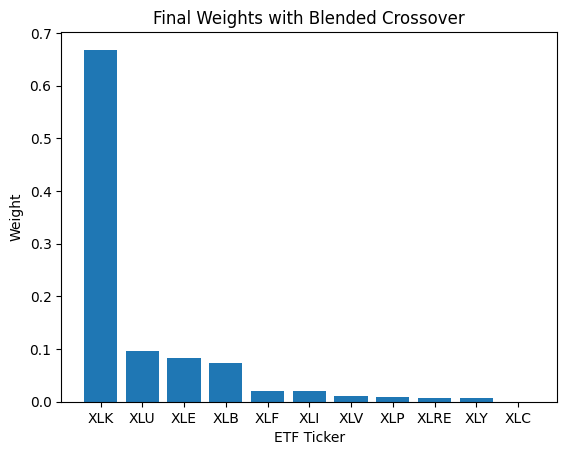

In [ ]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Blended_Crossover.png', dpi=300)

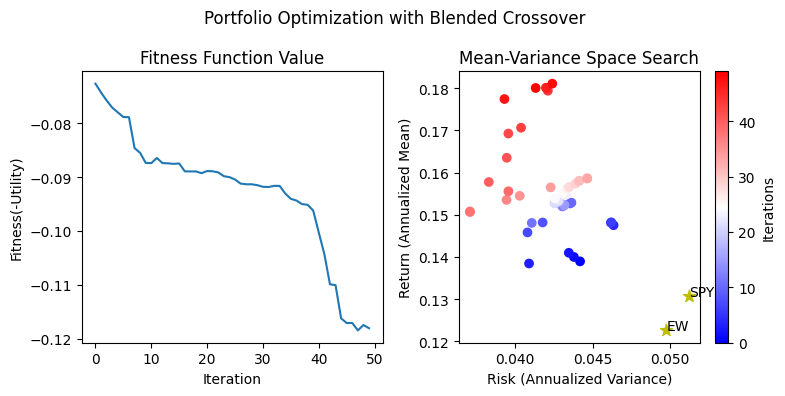

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Blended_Crossover.png', dpi=300)

## With Arithmetic Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
    return -portfolio_utility(cagrs, cov, weights, risk_aversion)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Arithmetic Crossover"
cross_over_func = arithmetic_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':portfolio_cagr(cagrs, elite[0]),
                         'risk':portfolio_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

100%|██████████| 50/50 [00:00<00:00, 70.69it/s]


In [ ]:
print("<<Optimization Result>>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (-Utility): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<<Optimal Solution (Weights)>>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<<Optimization Result>>
Return (Mean): 		0.1415
Risk (Variance): 	0.0451
fitness (-Utility): 	-0.0738

<<Optimal Solution (Weights)>>
XLC  (Communication Services) :	 0.0408
XLY  (Consumer Discretionary) :	 0.0427
XLP  (Consumer Staples)       :	 0.0544
XLE  (Energy)                 :	 0.1190
XLF  (Financials)             :	 0.0634
XLV  (Health Care)            :	 0.0820
XLI  (Industrials)            :	 0.1467
XLB  (Materials)              :	 0.1137
XLRE (Real Estate)            :	 0.0602
XLK  (Technology)             :	 0.2126
XLU  (Utilities)              :	 0.0645


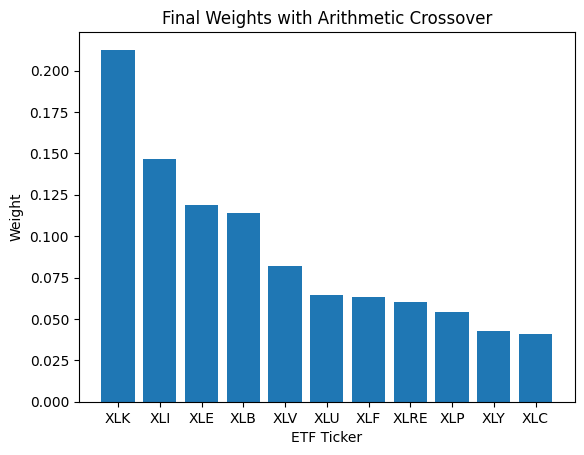

In [ ]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Arithmetic_Crossover.png', dpi=300)

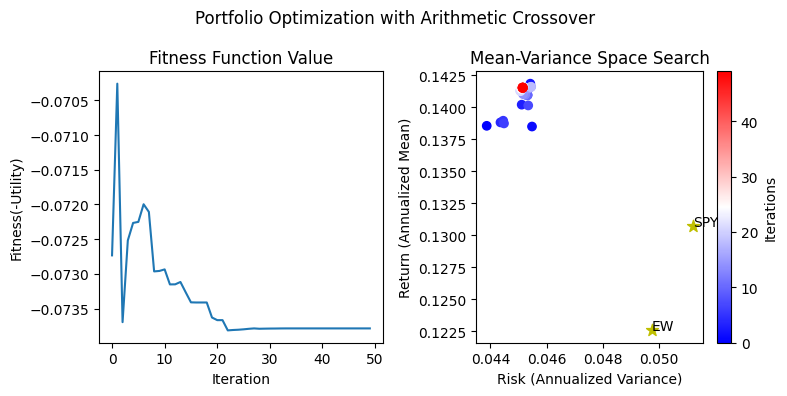

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Arithmetic_Crossover.png', dpi=300)

## With Uniform Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)
ra = 3 # intial setup

# modify utility function to univariate for convenience
def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
    return -portfolio_utility(cagrs, cov, weights, risk_aversion)

# initial parameters
n = len(tickers)
pop_size = 100

# initial population
population = np.array([generate_chromosome(n) for _ in range(pop_size)])

# select elite populatioin
elite = select_elite(population)

iterations = 50
result = dict()

# iterate for loop
cross_over_str = "Uniform Crossover"
cross_over_func = uniform_crossover
for iteration in tqdm(range(iterations)):
    population = next_generation(pop_size, elite, cross_over_func)
    elite = select_elite(population)
    result[iteration] = {'return':portfolio_cagr(cagrs, elite[0]),
                         'risk':portfolio_var(cov, elite[0]),
                         'utility':fitness(elite[0])}

df_result = pd.DataFrame(result).T

100%|██████████| 50/50 [00:00<00:00, 52.65it/s]


In [ ]:
print("<<Optimization Result>>")
print(f"Return (Mean): \t\t{df_result['return'][iterations-1]:.4f}")
print(f"Risk (Variance): \t{df_result['risk'][iterations-1]:.4f}")
print(f"fitness (-Utility): \t{df_result['utility'][iterations-1]:.4f}")
print("")
print("<<Optimal Solution (Weights)>>")
for i, v in zip(tickers, elite[0]):
    print(f"{i:<4} {('('+universe[i]+')'):<25}:\t {v:.4f}")

<<Optimization Result>>
Return (Mean): 		0.1461
Risk (Variance): 	0.0372
fitness (-Utility): 	-0.0903

<<Optimal Solution (Weights)>>
XLC  (Communication Services) :	 0.0022
XLY  (Consumer Discretionary) :	 0.0022
XLP  (Consumer Staples)       :	 0.0022
XLE  (Energy)                 :	 0.2016
XLF  (Financials)             :	 0.0022
XLV  (Health Care)            :	 0.0665
XLI  (Industrials)            :	 0.2016
XLB  (Materials)              :	 0.2016
XLRE (Real Estate)            :	 0.0022
XLK  (Technology)             :	 0.2360
XLU  (Utilities)              :	 0.0022


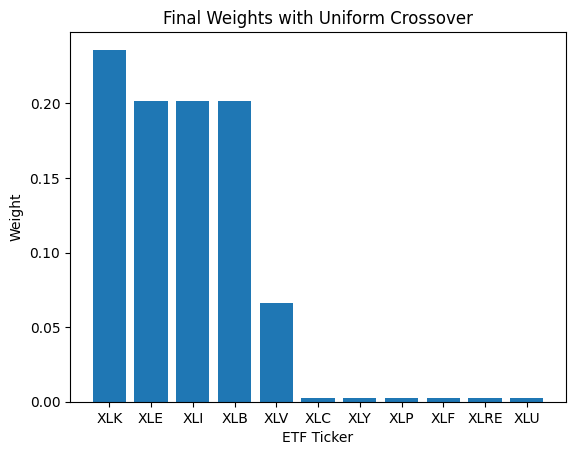

In [ ]:
# plot result weightings
fig, ax = plt.subplots()
ax.set_title(f'Final Weights with {cross_over_str}')
ax.set_xlabel('ETF Ticker')
ax.set_ylabel('Weight')

ax.bar(sorted(tickers, key=lambda x: elite[0][tickers.index(x)], reverse=True),
       sorted(elite[0], reverse=True))

_ = fig.figure.savefig('Final_Weights_Uniform_Crossover.png', dpi=300)

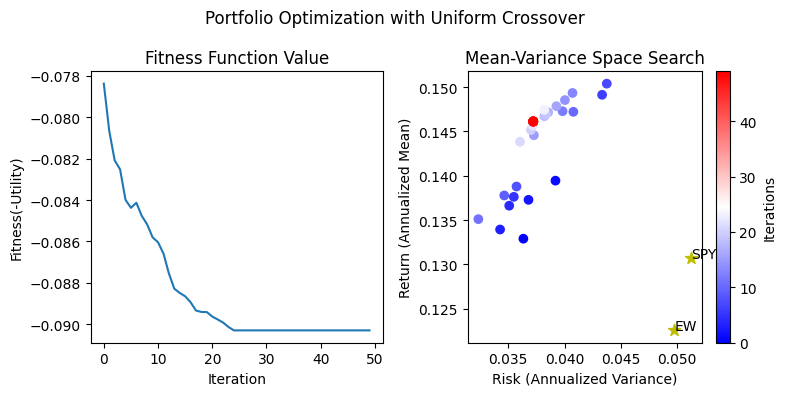

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Portfolio Optimization with {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result.index, df_result['utility'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result['risk'], df_result['return'],
            c=df_result.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result.index),
                            vmax=max(df_result.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Iterations')

fig.tight_layout()
_ = fig.figure.savefig('Optimization_Uniform_Crossover.png', dpi=300)

## Fitness(Utility) Sensitivity by Risk Aversion

### Blended Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)

results_ra = dict()

# risk aversion: 1 (low risk aversion) ~ 5 (high risk averssion)
for ra in tqdm(np.linspace(1, 5, 5+4*3)):
    # modify utility function to univariate for convenience
    def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
        return -portfolio_utility(cagrs, cov, weights, risk_aversion)

    # initial parameters
    n = len(tickers)
    pop_size = 100

    # initial population
    population = np.array([generate_chromosome(n) for _ in range(pop_size)])

    # select elite populatioin
    elite = select_elite(population)

    iterations = 50
    result = dict()

    # iterate for loop
    cross_over_str = "Blended Crossover"
    cross_over_func = blended_crossover
    for iteration in range(iterations):
        population = next_generation(pop_size, elite, cross_over_func)
        elite = select_elite(population)
    
    # save only the final step
    results_ra[ra] = {'return':portfolio_cagr(cagrs, elite[0]),
                      'risk':portfolio_var(cov, elite[0]),
                      'utility':fitness(elite[0])}

df_result_ra = pd.DataFrame(results_ra).T

100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


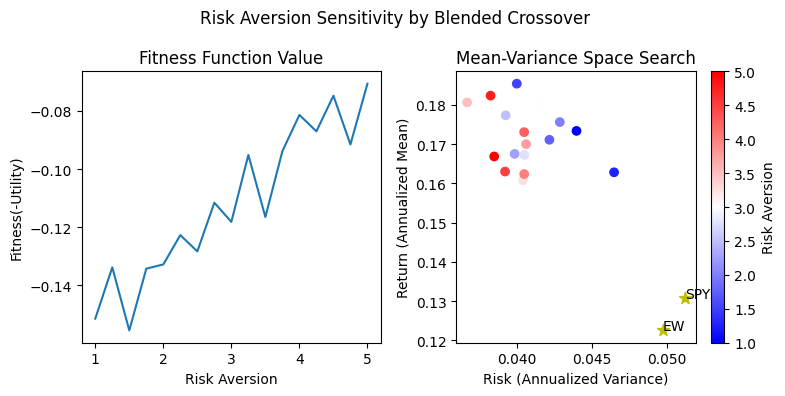

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Risk Aversion Sensitivity by {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result_ra.index, df_result_ra['utility'])
ax1.set_xlabel('Risk Aversion')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result_ra['risk'], df_result_ra['return'],
            c=df_result_ra.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result_ra.index),
                            vmax=max(df_result_ra.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Risk Aversion')

fig.tight_layout()
_ = fig.figure.savefig('Risk_Aversion_Blended_Crossover.png', dpi=300)

### Arithmetic Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)

results_ra = dict()

# risk aversion: 1 (low risk aversion) ~ 5 (high risk averssion)
for ra in tqdm(np.linspace(1, 5, 5+4*3)):
    # modify utility function to univariate for convenience
    def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
        return -portfolio_utility(cagrs, cov, weights, risk_aversion)

    # initial parameters
    n = len(tickers)
    pop_size = 100

    # initial population
    population = np.array([generate_chromosome(n) for _ in range(pop_size)])

    # select elite populatioin
    elite = select_elite(population)

    iterations = 50
    result = dict()

    # iterate for loop
    cross_over_str = "Arithmetic Crossover"
    cross_over_func = arithmetic_crossover
    for iteration in range(iterations):
        population = next_generation(pop_size, elite, cross_over_func)
        elite = select_elite(population)
    
    # save only the final step
    results_ra[ra] = {'return':portfolio_cagr(cagrs, elite[0]),
                      'risk':portfolio_var(cov, elite[0]),
                      'utility':fitness(elite[0])}

df_result_ra = pd.DataFrame(results_ra).T

100%|██████████| 17/17 [00:07<00:00,  2.25it/s]


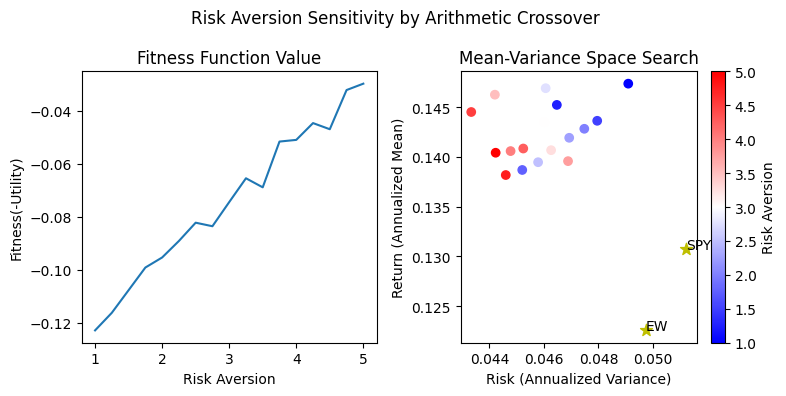

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Risk Aversion Sensitivity by {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result_ra.index, df_result_ra['utility'])
ax1.set_xlabel('Risk Aversion')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result_ra['risk'], df_result_ra['return'],
            c=df_result_ra.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result_ra.index),
                            vmax=max(df_result_ra.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Risk Aversion')

fig.tight_layout()
_ = fig.figure.savefig('Risk_Aversion_Arithmetic_Crossover.png', dpi=300)

### Uniform Crossover

In [ ]:
# constant parameters
cagrs = np.array([calculate_cagr(df_return[x]) for x in tickers])
cov = calculate_cov(df_return)

results_ra = dict()

# risk aversion: 1 (low risk aversion) ~ 5 (high risk averssion)
for ra in tqdm(np.linspace(1, 5, 5+4*3)):
    # modify utility function to univariate for convenience
    def fitness(weights, cagrs=cagrs, cov=cov, risk_aversion=ra):
        return -portfolio_utility(cagrs, cov, weights, risk_aversion)

    # initial parameters
    n = len(tickers)
    pop_size = 100

    # initial population
    population = np.array([generate_chromosome(n) for _ in range(pop_size)])

    # select elite populatioin
    elite = select_elite(population)

    iterations = 50
    result = dict()

    # iterate for loop
    cross_over_str = "Uniform Crossover"
    cross_over_func = uniform_crossover
    for iteration in range(iterations):
        population = next_generation(pop_size, elite, cross_over_func)
        elite = select_elite(population)
    
    # save only the final step
    results_ra[ra] = {'return':portfolio_cagr(cagrs, elite[0]),
                      'risk':portfolio_var(cov, elite[0]),
                      'utility':fitness(elite[0])}

df_result_ra = pd.DataFrame(results_ra).T

100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


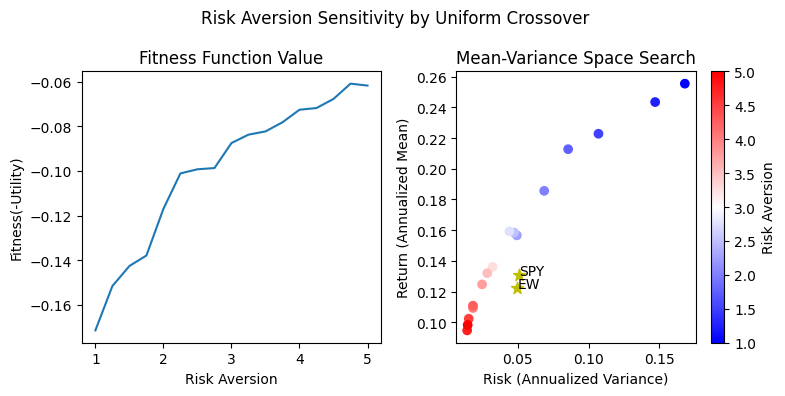

In [ ]:
# plot optimization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle(f'Risk Aversion Sensitivity by {cross_over_str}')

# fitness plot
ax1.set_title('Fitness Function Value')
ax1.plot(df_result_ra.index, df_result_ra['utility'])
ax1.set_xlabel('Risk Aversion')
ax1.set_ylabel('Fitness(-Utility)')

# mean variance plot
ax2.set_title('Mean-Variance Space Search')
ax2.scatter(df_result_ra['risk'], df_result_ra['return'],
            c=df_result_ra.index, cmap='bwr')
ax2.set_xlabel('Risk (Annualized Variance)')
ax2.set_ylabel('Return (Annualized Mean)')

# benchmark
ax2.scatter(df_mv['risk']['SPY'], df_mv['return']['SPY'],
            c='y', s=80, marker="*")
ax2.scatter(df_mv['risk']['EW'], df_mv['return']['EW'],
            c='y', s=80, marker="*")
ax2.annotate("SPY", (df_mv['risk']['SPY'], df_mv['return']['SPY']))
ax2.annotate("EW", (df_mv['risk']['EW'], df_mv['return']['EW']))

# cmap
norm = mpl.colors.Normalize(vmin=min(df_result_ra.index),
                            vmax=max(df_result_ra.index))
colormapping = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
cbar = fig.colorbar(colormapping, ax=plt.gca())
cbar.set_label('Risk Aversion')

fig.tight_layout()
_ = fig.figure.savefig('Risk_Aversion_Uniform_Crossover.png', dpi=300)